# Libraries

In [25]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
from scipy import signal, linalg

from numpy.linalg import inv
from scipy.optimize import fmin_bfgs
import pandas as pd
from pandas import read_csv
import time

import pylab

plt.rcParams['figure.figsize'] = (10,5)

# Simulation Function

In [26]:
def simulate(datagen, N, arma, n, m, k , q, projection=True):
    # n : number of simulations
    # N : length of the simulations
    # arma : expected a function such as : arma_ons, amra_ogd...
    #############
    
    list_sim_loss = []
    list_sim_nabla = []
    list_sim_L = []
    
    for i in range(n):
        # simulate data
        X = datagen(N)
        # get historical parameter and loss
 
        X_p, loss_hist, nabla_hist, L_hist = arma(X, m, k, q, projection)
        
        list_sim_loss.append(loss_hist)
        list_sim_nabla.append(nabla_hist) 
        list_sim_L.append(L_hist)
        
    return np.array(list_sim_loss), np.array(list_sim_nabla), np.array(list_sim_L)

# ARMA OGD

In [27]:
def arma_ogd(X, m, k, q, projection=True):
    """
    arma online gradient descent
    ici on prend c = 1 (majore les gamma en valeur absolue)
    """
    # D    : Diameter of parameter space
    # G    : Gradient loss
    # Square Loss -> lambda-exp-concave avec lambda = 1 / (m + k)
    # rate : Eta
    # A    : Proxy of Hessian
    ##############################
    c = 1
    Xmax = 10
    D = 2 * c * np.sqrt((m + k))
    G = 2 * c * np.sqrt(m + k) * Xmax**2
    lambda_ = 1.0 / (m + k) 
    T = X.shape[0]
    
    rate = D/(G * np.sqrt(T))
    # print(rate)
    L = np.matrix(np.random.uniform(-c, c, (m + k, 1)))
    X_p = np.zeros(T)
    
    loss_hist = np.zeros(T)
    nabla_norm_hist = np.zeros(T)
    L_hist = np.zeros(T)
    
    for t in range(T):
        #----- Predict ----
        #------------------
        X_t = 0
        for i in range(m + k):
            if t-i-1 < 0:
                break
            X_t += L[i] * X[t-i-1]
        X_p[t] = X_t

        #----- Loss -------
        #------------------
        loss_hist[t] = 0.5 * (X[t]-X_t)**2

        #----- Update -----
        #------------------
        nabla = np.zeros((m + k, 1))
        for i in range(m + k):
            x = X[t-i-1] if t-i-1 >= 0 else 0
            nabla[i, 0] = - 2 * (X[t] - X_t) * x
        nabla_norm_hist[t] = np.linalg.norm(nabla, 2)
        
        L = L - rate * nabla
        if projection:
            L_norm = max(L.max(), -L.min())
            if L_norm > c:
                L /= L_norm
                L *= c
            
        L_hist[t] = L.max()
        # print("\r", L.max(), "\t", loss_hist[t])
        
        #Sherman–Morrison formula for inverting A :
        #lambda_ = (1 / (1.0 + np.dot(np.dot(nabla.T, A_inv), nabla)[0,0]))
        #A_inv = A_inv - lambda_ * np.dot(A_inv, hess, A_inv)
        
    return X_p, loss_hist, nabla_norm_hist, L_hist


# ARMA ONS

In [28]:
import time

def arma_ons(X, m, k, q, projection=True):
    """
    arma online newton step
    here we take c = 1 (plus gamma in absolute value)
    """
    # D    : Length of parameter space
    # G    : Gradient loss
    # Square Loss -> lambda-exp-concave with lambda = 1 / (m + k)
    # rate : Eta
    # A    : Proxy of Hessian
    ##############################
    c = 1
    Xmax = 10
    D = 2 * c * np.sqrt((m + k))
    G = 2 * c * np.sqrt(m + k) * Xmax**2
    lambda_ = 1.0 / (m + k) 
    
    rate = 0.5 * min(4*G*D, lambda_)
    
    epsilon = 1.0 / (rate**2 * D**2)
    
    A = np.matrix(np.diag([1] * (m + k)) * epsilon)
    
    L = np.matrix(np.random.uniform(-c, c, (m + k, 1)))
    
    T = X.shape[0]

    X_p = np.zeros(T)
    
    loss_hist = np.zeros(T)
    nabla_norm_hist = np.zeros(T)
    L_hist = np.zeros(T)
    
    for t in range(T):
        #----- Predict ----
        #------------------
        X_t = 0
        for i in range(m + k):
            if t-i-1 < 0:
                break
            X_t += L[i] * X[t-i-1]
        X_p[t] = X_t

        #----- Loss -------
        #------------------
        loss_hist[t] = 0.5 * (X[t]-X_t)**2

        #----- Update -----
        #------------------
        nabla = np.zeros((m+k, 1))
        for i in range(m+k):
            x = X[t-i-1] if t-i-1 >= 0 else 0
            nabla[i, 0] = -2 * (X[t]-X_t) * x
        
        nabla_norm_hist[t] = np.linalg.norm(nabla, 2)
        
        hess = np.dot(nabla, nabla.T)
        A = A + hess
        L = L - 1/rate*np.dot(inv(A) , nabla)
        if projection:
            L_norm = max(L.max(), -L.min())
            if L_norm > c:
                L /= L_norm
                L *= c
            
        L_hist[t] = L.max()
        
        #Sherman–Morrison formula for inverting A :
        #lambda_ = (1 / (1.0 + np.dot(np.dot(nabla.T, A_inv), nabla)[0,0]))
        #A_inv = A_inv - lambda_ * np.dot(A_inv, hess, A_inv)
        
    return X_p, loss_hist, nabla_norm_hist, L_hist

# Plot Simulations

In [29]:
def plot_simulations_results(title, arma, data_gen, k, q, T=1000, iters=200):
    t0 = time.time()

    print(title)

    
    m = int(np.round(q*np.log(T)))
    sim_loss, sim_nabla, sim_L = simulate(data_gen, T, arma, iters, m, k, q, projection=True)

    plt.subplot(221, )
    moy_loss = sim_loss.mean(axis=0) #gen_errors(loss)
    plt.plot(moy_loss)
    plt.ylim(ymax=1.5, ymin=0)
    plt.title("Loss")

    #plt.subplot(222)
    #moy_gradient_norme = sim_nabla.mean(axis=0)
    #plt.plot(moy_gradient_norme)
    #plt.title("Norme du gradient")

    #plt.subplot(222)
    #moy_parametre_norme = sim_L.mean(axis=0)
    #plt.plot(moy_parametre_norme)
    #plt.ylim(ymax=0.55)
    #plt.title("Norme du paramètre")

    print("time : {}".format(round(time.time()-t0, 2)))
    return sim_loss, sim_nabla, sim_L

# Plot Data

In [30]:
# List to record simulation results.
ONS_sim_loss = [[]]*6
ONS_sim_L = [[]]*6

OGD_sim_loss = [[]]*6
OGD_sim_L = [[]]*6

YL_sim_loss = [[]]*6

#New sim loss
RL_sim_loss = [[]]*6

# Slowly Changing Coefficients

In [31]:
def gen_dataset4(n_samples=10000):
    alpha = np.array([0.11, -0.5])
    beta = np.array([0.41, -0.39, -0.685, 0.1])
    a = 2
    b = 4
    sigma = 0.3

    noise = 0
    noises = [0]*b
    arma = [0]*a
    for i in range(n_samples):
        noise = np.random.normal(noise, sigma)
        x = np.sum(arma[:-a-1:-1] * alpha)
        x += np.sum(noises[:-b-1:-1] * beta)
        x += noise
        arma.append(x)
        noises.append(noise)
    arma = np.array(arma[a:])
    return arma

Red Curve: Simulated Data
Blue curve: predicted values


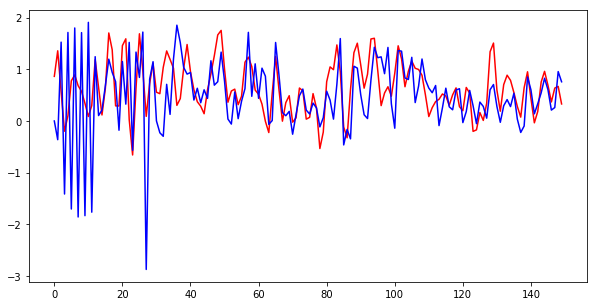

In [32]:
X = gen_dataset4(150)
X_p, loss, nablas, Ls = arma_ons(X, 5, 5, 0)
t = range(150)
plt.plot(t, X, color="red")
plt.plot(t, X_p, color="blue")
print("Red Curve: Simulated Data")
print("Blue curve: predicted values")

### OGD Simulation

ARMA-OGD
time : 23.64


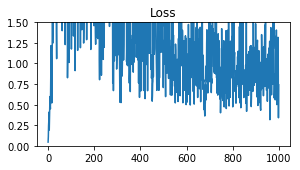

In [95]:
OGD_sim_loss[3], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset4, k=2, q=4, T=1000, iters=20)

### ONS Simulation

ARMA-ONS
time : 29.96


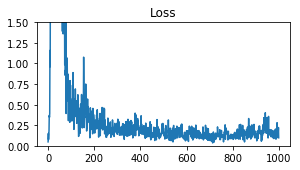

In [96]:
ONS_sim_loss[3], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset4, k=2, q=4, T=1000, iters=20)

### Comparison Graph

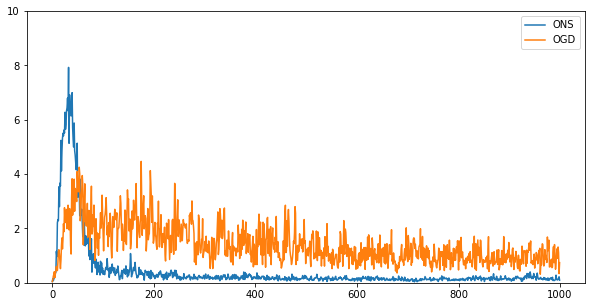

In [97]:
pylab.plot(ONS_sim_loss[3].mean(0), label = 'ONS')
pylab.plot(OGD_sim_loss[3].mean(0), label = 'OGD')
pylab.legend(loc = 'upper right')
pylab.ylim(0.0,10)
pylab.show()

# Performance Check

### ONS Check

In [98]:
(ONS_sim_loss[3].mean(0)).mean()

0.45637942161806827

### OGD Check

In [99]:
(OGD_sim_loss[3].mean(0)).mean()

1.4127874621065475

# SMOOTHING TEST

## ONS Smooth

/Users/siddharth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


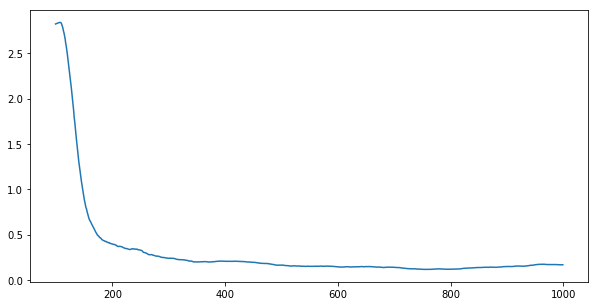

In [100]:
smooth_data_ONS = pd.rolling_mean(ONS_sim_loss[3].mean(0),100)
pylab.plot(smooth_data_ONS)

## OGD Smooth

/Users/siddharth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


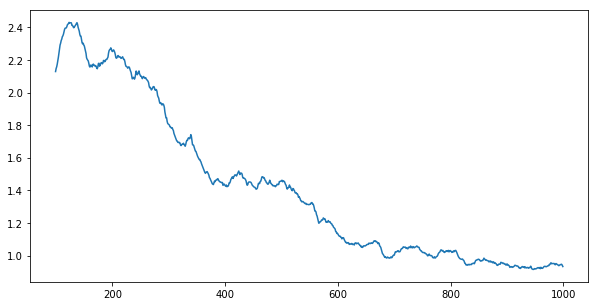

In [101]:
smooth_data_OGD = pd.rolling_mean(OGD_sim_loss[3].mean(0),100)
pylab.plot(smooth_data_OGD)

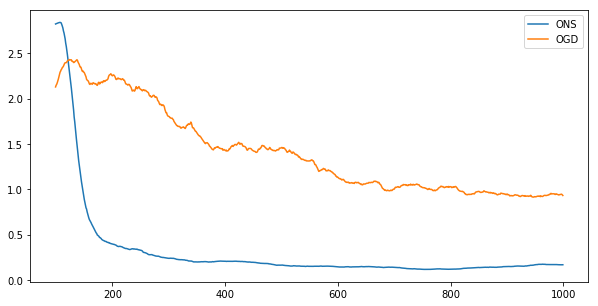

In [102]:
pylab.plot(smooth_data_ONS, label = 'ONS')
pylab.plot(smooth_data_OGD, label = 'OGD')
pylab.legend(loc = 'upper right')
#pylab.ylim(0,10)
#pylab.xlim(0.0,3000)
pylab.show()

ARMA-OGD
time : 291.68


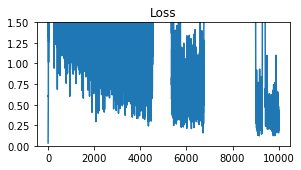

In [81]:
OGD_sim_loss[3], _, _ = plot_simulations_results("ARMA-OGD", arma_ogd, gen_dataset4, k=2, q=4, T=10000, iters=20)

ARMA-ONS
time : 337.9


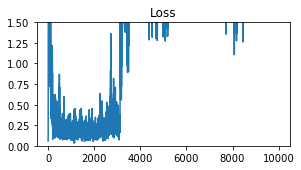

In [82]:
ONS_sim_loss[3], _, _ = plot_simulations_results("ARMA-ONS", arma_ons, gen_dataset4, k=2, q=4, T=10000, iters=20)

In [83]:
(ONS_sim_loss[3].mean(0)).mean()

2.8300318015615225

In [84]:
(OGD_sim_loss[3].mean(0)).mean()

3358.1235504631541

In [87]:
smooth_data_ONS = pd.rolling_mean(ONS_sim_loss[3].mean(0),1000)


/Users/siddharth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


In [88]:
smooth_data_OGD = pd.rolling_mean(OGD_sim_loss[3].mean(0),1000)


/Users/siddharth/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """Entry point for launching an IPython kernel.


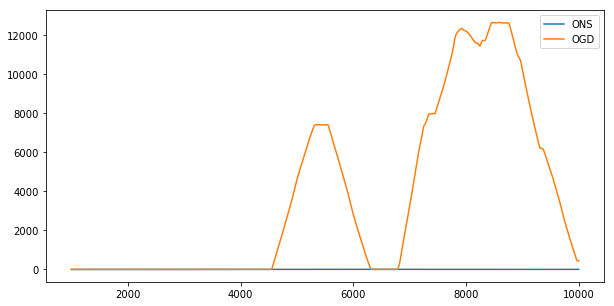

In [90]:
pylab.plot(smooth_data_ONS, label = 'ONS')
pylab.plot(smooth_data_OGD, label = 'OGD')
pylab.legend(loc = 'upper right')
#pylab.ylim(0,10)
#pylab.xlim(0.0,3000)
pylab.show()

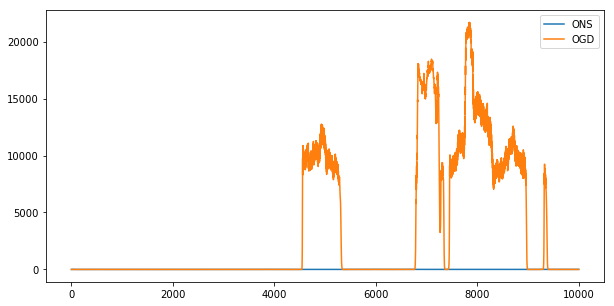

In [92]:
pylab.plot(ONS_sim_loss[3].mean(0), label = 'ONS')
pylab.plot(OGD_sim_loss[3].mean(0), label = 'OGD')
pylab.legend(loc = 'upper right')
#pylab.ylim(0.0,10)
pylab.show()

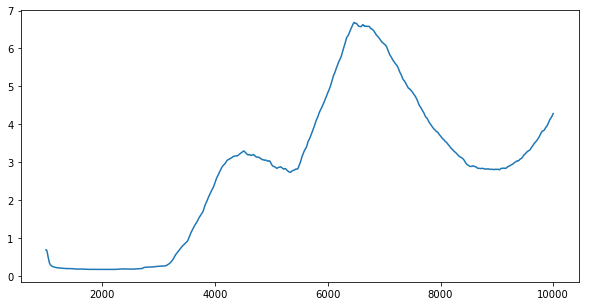

In [93]:
pylab.plot(smooth_data_ONS, label = 'ONS')


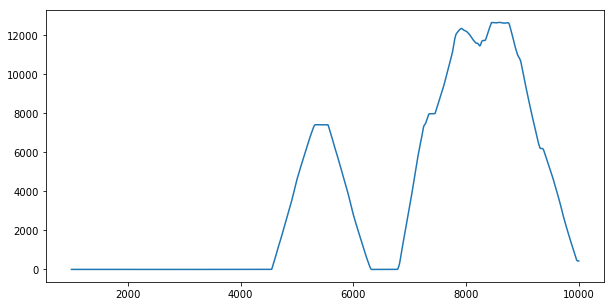

In [94]:
pylab.plot(smooth_data_OGD, label = 'OGD')
